# Part I: Multi-asset risk & porfolio management

# 0 Setup

In [ ]:
!pip -q install yfinance cvxpy arch numpy pandas matplotlib scipy

import numpy as np, pandas as pd, matplotlib.pyplot as plt
import yfinance as yf
import cvxpy as cp
from arch import arch_model
from scipy.stats import norm, chi2

pd.options.display.float_format = "{:,.6f}".format
np.set_printoptions(precision=6, suppress=True)

# Universe and Dates
TICKERS = ["AAPL","MSFT","AMZN","GOOGL","META", "JPM","GS","BAC"]  # add/remove freely
YEARS_BACK = 20              # download window
IS_YEARS   = 2               # in-sample length for per-asset model fit
ALPHA      = 0.95
LAMBDA     = 0.94            # EWMA lambda
RF_ANNUAL  = 0.03            # risk-free for options carry / annualized stats

# Portfolio
LOOKBACK_M = 36              # months for rolling estimation
GAMMA_MVO  = 5.0
GAMMA_MCV  = 5.0             # Mean-CVaR penalty

# Misc
RIDGE = 1e-8
SEED  = 42
rng   = np.random.default_rng(SEED)

today = pd.Timestamp.today().normalize()
start = (today - pd.DateOffset(years=YEARS_BACK)).date()
end   = today.date()
print("Download:", start, "→", end)


Download: 2005-09-06 → 2025-09-06


# 1 Data download, returns, alignment + coverage check

# 2 Risk helpers (VaR/ES, EWMA, tests)

In [ ]:
def ewma_sigma_last(r: pd.Series, lam=LAMBDA) -> float:
    r = pd.Series(r).dropna()
    v=0.0
    for x in r.values:
        v = lam*v + (1-lam)*x*x
    return float(np.sqrt(v))

def var_es_normal(mu, sigma, alpha=ALPHA):
    z = norm.ppf(1-alpha)
    var = mu + sigma*z
    es  = mu - sigma*norm.pdf(z)/(1-alpha)
    return float(var), float(es)

def var_es_hist(r: pd.Series, alpha=ALPHA):
    r = pd.Series(r).dropna().sort_values()
    q = r.quantile(1-alpha, interpolation="lower")
    es = r[r<=q].mean() if (r<=q).any() else q
    return float(q), float(es)

def kupiec_pof(hits, n, alpha=ALPHA):
    if n==0 or hits in (0,n): return np.nan, np.nan
    p = 1-alpha; ph = hits/n
    LR = -2*np.log(((1-p)**(n-hits)*(p**hits))/(((1-ph)**(n-hits))*(ph**hits)))
    return float(LR), float(1-chi2.cdf(LR,1))


# 3 Per-asset models: ML (sample), EWMA, GARCH + VaR/ES table + Kupiec backtests

In [ ]:
def fit_vol_models(r_series: pd.Series):
    r = pd.Series(r_series).dropna()
    mu_ml, sig_ml = r.mean(), r.std()                # sample (aka "ML" here = sample stats)
    sig_ew = ewma_sigma_last(r, lam=LAMBDA)
    # GARCH(1,1) with Student-t
    am  = arch_model(r.values*100, vol="GARCH", p=1, q=1, mean="constant", dist="t")
    res = am.fit(disp="off")
    sig_g = float(np.sqrt(res.forecast(horizon=1).variance.values[-1,0])/100.0)
    mu_g  = float(res.params["mu"]/100.0)
    return dict(ML=(float(mu_ml), float(sig_ml)),
                EWMA=(0.0, float(sig_ew)),
                GARCH=(float(mu_g), float(sig_g)))

def per_ticker_tables(r_is_df: pd.DataFrame, r_oos_df: pd.DataFrame, alpha=ALPHA):
    rows_var_es, rows_bt = [], []
    for t in r_is_df.columns:
        models = fit_vol_models(r_is_df[t])

        # Parametric VaR/ES
        for name,(mu,sig) in models.items():
            v,e = var_es_normal(mu, sig, alpha)
            rows_var_es.append([t, name, alpha, v, e])

        # Historical VaR/ES
        v_h, e_h = var_es_hist(r_is_df[t], alpha)
        rows_var_es.append([t, "HIST", alpha, v_h, e_h])

        # Backtests on OOS
        n_oos = len(r_oos_df[t].dropna())
        for name,(mu,sig) in models.items():
            v,_ = var_es_normal(mu, sig, alpha)
            hits = int((r_oos_df[t] < v).sum())
            LR, p = kupiec_pof(hits, n_oos, alpha)
            rows_bt.append([t, name, alpha, hits, (1-alpha)*n_oos, v, LR, p])

        hits_h = int((r_oos_df[t] < v_h).sum())
        LR_h, p_h = kupiec_pof(hits_h, n_oos, alpha)
        rows_bt.append([t, "HIST", alpha, hits_h, (1-alpha)*n_oos, v_h, LR_h, p_h])

    var_table = pd.DataFrame(rows_var_es, columns=["Ticker","Model","Alpha","VaR","ES"])
    bt_table  = pd.DataFrame(rows_bt, columns=["Ticker","Model","Alpha","Exceed","Expected","VaR","Kupiec_LR","Kupiec_p"])
    return var_table, bt_table

var_table, bt_table = per_ticker_tables(r_is, r_oos, alpha=ALPHA)
display(var_table.sort_values(["Ticker","Model"]))
display(bt_table.sort_values(["Ticker","Model"]))


,Ticker,Model,Alpha,VaR,ES
1,AAPL,EWMA,0.950000,-0.017478,-0.021918
2,AAPL,GARCH,0.950000,-0.018741,-0.023832
3,AAPL,HIST,0.950000,-0.020749,-0.028981
0,AAPL,ML,0.950000,-0.020905,-0.026553
5,AMZN,EWMA,0.950000,-0.029111,-0.036506
6,AMZN,GARCH,0.950000,-0.027529,-0.034974
7,AMZN,HIST,0.950000,-0.026724,-0.040284
4,AMZN,ML,0.950000,-0.029761,-0.037807
9,BAC,EWMA,0.950000,-0.021226,-0.026618
10,BAC,GARCH,0.950000,-0.023618,-0.029742


,Ticker,Model,Alpha,Exceed,Expected,VaR,Kupiec_LR,Kupiec_p
1,AAPL,EWMA,0.950000,26,8.450000,-0.017478,25.336779,0.000000
2,AAPL,GARCH,0.950000,25,8.450000,-0.018741,22.903338,0.000002
3,AAPL,HIST,0.950000,22,8.450000,-0.020749,16.179731,0.000058
0,AAPL,ML,0.950000,22,8.450000,-0.020905,16.179731,0.000058
5,AMZN,EWMA,0.950000,10,8.450000,-0.029111,0.283386,0.594491
6,AMZN,GARCH,0.950000,11,8.450000,-0.027529,0.742752,0.388781
7,AMZN,HIST,0.950000,11,8.450000,-0.026724,0.742752,0.388781
4,AMZN,ML,0.950000,9,8.450000,-0.029761,0.036933,0.847602
9,BAC,EWMA,0.950000,10,8.450000,-0.021226,0.283386,0.594491
10,BAC,GARCH,0.950000,10,8.450000,-0.023618,0.283386,0.594491


# 4 Portfolio: rolling monthly MVO and Mean-CVaR

In [ ]:
def est_mu_sigma(win: pd.DataFrame):
    mu = win.mean().values
    S  = win.cov().values
    S  = 0.5*(S+S.T) + RIDGE*np.eye(S.shape[0])
    return mu, S

def solve_mvo(mu, S, gamma=GAMMA_MVO, long_only=True):
    n = len(mu); w = cp.Variable(n)
    obj = cp.Maximize(mu @ w - 0.5*gamma*cp.quad_form(w, S))
    cons = [cp.sum(w)==1]
    if long_only: cons += [w>=0]
    prob = cp.Problem(obj, cons)
    for solver in [cp.ECOS, cp.OSQP, cp.SCS]:
        try:
            prob.solve(solver=solver, verbose=False)
            if w.value is not None and prob.status in ("optimal","optimal_inaccurate"):
                return np.asarray(w.value).ravel()
        except: pass
    raise RuntimeError("MVO solver failed")

def solve_meancvar(win: pd.DataFrame, alpha=ALPHA, gamma=GAMMA_MCV, long_only=True):
    R = win.values; N,n = R.shape
    w = cp.Variable(n); t = cp.Variable(); xi = cp.Variable(N)
    L = -(R @ w)  # loss
    cvar = t + (1/((1-alpha)*N)) * cp.sum(xi)
    mu = win.mean().values
    obj = cp.Maximize(mu @ w - gamma * cvar)
    cons = [cp.sum(w)==1, xi>=0, xi>=L-t]
    if long_only: cons += [w>=0]
    prob = cp.Problem(obj, cons)
    for solver in [cp.ECOS, cp.OSQP, cp.SCS]:
        try:
            prob.solve(solver=solver, verbose=False)
            if w.value is not None and prob.status in ("optimal","optimal_inaccurate"):
                return np.asarray(w.value).ravel()
        except: pass
    raise RuntimeError("Mean-CVaR solver failed")


In [ ]:
# Monthly data & rolling fit
px_m  = px.resample("M").last().dropna(how="all")
ret_m = px_m.pct_change().dropna()

W_MVO, W_MCV, out_dates = [], [], []
dates = ret_m.index
for i in range(LOOKBACK_M, len(dates)-1):
    win = ret_m.iloc[i-LOOKBACK_M:i]
    try:
        w1 = solve_mvo(*est_mu_sigma(win), gamma=GAMMA_MVO, long_only=True)
        w2 = solve_meancvar(win, alpha=ALPHA, gamma=GAMMA_MCV, long_only=True)
    except Exception as e:
        # if an iteration fails (ill-conditioned), skip this rebal date
        # you can also fall back to equal-weights: w1 = w2 = np.ones(win.shape[1])/win.shape[1]
        continue
    W_MVO.append(w1); W_MCV.append(w2); out_dates.append(dates[i+1])

W_MVO = pd.DataFrame(np.vstack(W_MVO), index=out_dates, columns=ret_m.columns)
W_MCV = pd.DataFrame(np.vstack(W_MCV), index=out_dates, columns=ret_m.columns)

# Portfolio OOS (monthly at rebalance dates)
port_mvo   = (W_MVO * ret_m.loc[W_MVO.index]).sum(1)
port_mcvar = (W_MCV * ret_m.loc[W_MCV.index]).sum(1)


/tmp/ipython-input-1559275740.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  px_m  = px.resample("M").last().dropna(how="all")
/usr/local/lib/python3.12/dist-packages/cvxpy/problems/problem.py:1510: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


# 5 Reporting - tables & plots (multi-asset)

,CAGR,Vol,Sharpe,MaxDD
AAPL,-11.87%,36.67%,-0.16,-31.25%
AMZN,2.14%,35.96%,0.24,-32.46%
BAC,17.98%,30.20%,0.70,-28.75%
GOOGL,30.79%,34.01%,0.96,-30.64%
GS,40.87%,34.28%,1.17,-32.07%
JPM,34.19%,26.82%,1.23,-25.29%
MSFT,23.79%,26.47%,0.94,-21.11%


,CAGR,Vol,Sharpe,MaxDD
MVO,23.33%,22.79%,1.04,-32.90%
Mean-CVaR,23.31%,20.04%,1.15,-29.66%


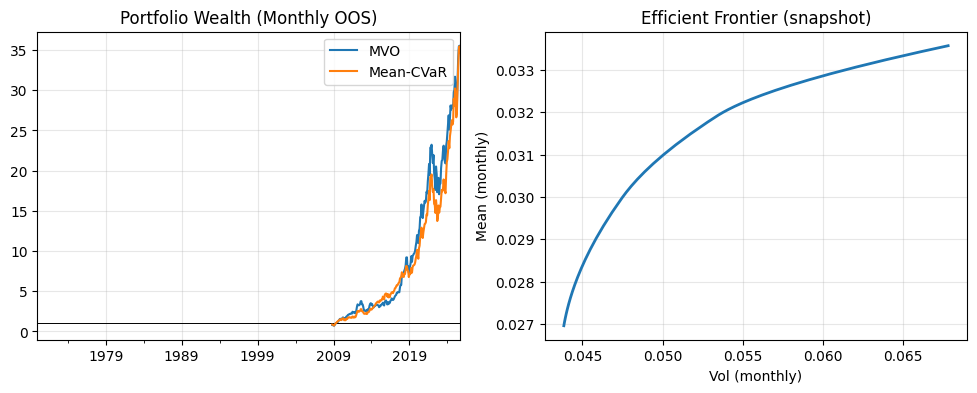

,Ticker,Model,Alpha,Exceed,Expected,VaR,Kupiec_LR,Kupiec_p
1,AAPL,EWMA,0.950000,26,8.5,-1.748%,25.337,0.000
2,AAPL,GARCH,0.950000,25,8.5,-1.874%,22.903,0.000
3,AAPL,HIST,0.950000,22,8.5,-2.075%,16.180,0.000
0,AAPL,ML,0.950000,22,8.5,-2.090%,16.180,0.000
5,AMZN,EWMA,0.950000,10,8.5,-2.911%,0.283,0.594
6,AMZN,GARCH,0.950000,11,8.5,-2.753%,0.743,0.389
7,AMZN,HIST,0.950000,11,8.5,-2.672%,0.743,0.389
4,AMZN,ML,0.950000,9,8.5,-2.976%,0.037,0.848
9,BAC,EWMA,0.950000,10,8.5,-2.123%,0.283,0.594
10,BAC,GARCH,0.950000,10,8.5,-2.362%,0.283,0.594


In [ ]:
def perf_series(ret, freq=12):
    ret = pd.Series(ret).dropna()
    if ret.empty:
        return pd.Series({"CAGR":np.nan,"Vol":np.nan,"Sharpe":np.nan,"MaxDD":np.nan})
    af  = 12 if freq==12 else 252
    cagr = (1+ret).prod()**(af/len(ret)) - 1
    vol  = ret.std() * np.sqrt(af)
    wealth = (1+ret).cumprod()
    dd = (wealth/wealth.cummax() - 1).min()
    sr   = (ret.mean()/ret.std())*np.sqrt(af) if ret.std()>0 else np.nan
    return pd.Series({"CAGR":cagr,"Vol":vol,"Sharpe":sr,"MaxDD":dd})

# 5a) Per-asset summary (OOS)
asset_oos_perf = pd.concat(
    {t: perf_series(r_oos[t], freq=252) for t in r_oos.columns}, axis=1
).T
display(asset_oos_perf.style.format({"CAGR":"{:.2%}","Vol":"{:.2%}","Sharpe":"{:.2f}","MaxDD":"{:.2%}"}))

# 5b) Portfolio performance (monthly)
port_table = pd.concat({
    "MVO":      perf_series(port_mvo,   freq=12),
    "Mean-CVaR":perf_series(port_mcvar, freq=12),
}, axis=1).T
display(port_table.style.format({"CAGR":"{:.2%}","Vol":"{:.2%}","Sharpe":"{:.2f}","MaxDD":"{:.2%}"}))

# 5c) Plots
fig, ax = plt.subplots(1,2, figsize=(12,4))
(1+port_mvo).cumprod().plot(ax=ax[0], label="MVO"); ax[0].axhline(1, color="k", lw=.7)
(1+port_mcvar).cumprod().plot(ax=ax[0], label="Mean-CVaR")
ax[0].set_title("Portfolio Wealth (Monthly OOS)"); ax[0].legend(); ax[0].grid(alpha=.3)

# Efficient frontier snapshot: last estimation window
if not W_MVO.empty:
    last_win = ret_m.loc[:W_MVO.index[-1]].iloc[-LOOKBACK_M:]
    mu, S = est_mu_sigma(last_win)
    # grid portfolios along direction of risk aversion
    gammas = np.geomspace(0.5, 50, 50)
    pts=[]
    for g in gammas:
        try:
            w = solve_mvo(mu,S,gamma=g,long_only=True)
            r = mu @ w
            v = np.sqrt(max(0, w @ S @ w))
            pts.append([v, r])
        except: pass
    pts = np.array(pts)
    if len(pts):
        ax[1].plot(pts[:,0], pts[:,1], lw=2)
        ax[1].set_title("Efficient Frontier (snapshot)")
        ax[1].set_xlabel("Vol (monthly)"); ax[1].set_ylabel("Mean (monthly)")
        ax[1].grid(alpha=.3)
plt.show()

# 5d) VaR backtests summary
display(
    bt_table.sort_values(["Ticker","Model"]).style.format({
        "Exceed":"{:,.0f}","Expected":"{:,.1f}","VaR":"{:.3%}","Kupiec_LR":"{:.3f}","Kupiec_p":"{:.3f}"
    })
)


# 6 Per-ticker backtests, then portfolio aggregation

# 6.1 Knobs + Black-Scholes helpers

In [ ]:
# Options Knobs
TC_BP        = 5          # transaction cost in bps per share notional per trade (0.05% default)
DIV_YIELD    = 0.00       # continuous dividend yield assumption
RF_ANNUAL    = 0.03       # annual risk-free for carry
HEDGE_FREQ   = "D"        # "D" = daily delta-hedge, "W" = weekly hedge (Mondays)

from math import log, sqrt, exp
from scipy.stats import norm

def bs_call_price(S, K, T, r, q, sigma):
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return max(0.0, S*exp(-q*T) - K*exp(-r*T))
    d1 = (log(S/K) + (r - q + 0.5*sigma*sigma)*T) / (sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    return exp(-q*T)*S*norm.cdf(d1) - exp(-r*T)*K*norm.cdf(d2)

def bs_call_delta(S, K, T, r, q, sigma):
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return 0.0
    d1 = (log(S/K) + (r - q + 0.5*sigma*sigma)*T) / (sigma*sqrt(T))
    return float(exp(-q*T)*norm.cdf(d1))

def rolling_ewma_ann_sigma(r: pd.Series, lam=0.94):
    """Return rolling annualized sigma series (sqrt(252) factor). Shifted 0 (uses info up to t)."""
    r = pd.Series(r).dropna()
    v = 0.0; out = []
    for x in r.values:
        v = lam*v + (1-lam)*x*x
        out.append(v)
    sig_d = pd.Series(np.sqrt(out), index=r.index)
    return sig_d * np.sqrt(252.0)


# 6.2 Strategy backtester for a single ticker

N: Short 1 ATM call each day; P&L = −ΔOption + risk-free carry on cash.

H: Same short call, delta-hedged with stock; includes TC on hedge trades.

ATM strike reset each day to yesterday’s close (simple, reproducible).

Hedge daily (or weekly if HEDGE_FREQ="W").

In [ ]:
def backtest_options_ticker(px_one: pd.Series,
                            r_log_one: pd.Series,
                            rf_annual=RF_ANNUAL,
                            lam=LAMBDA,
                            div_yield=DIV_YIELD,
                            tc_bp=TC_BP,
                            hedge_freq=HEDGE_FREQ):
    """
    Returns two daily P&L series (Strategy N, Strategy H) indexed by OOS dates.
    """
    # Build OOS segment aligned to both price and returns
    px_oos  = px_one.loc[str(OOS_START):str(OOS_END)].dropna()
    r_oos   = r_log_one.loc[px_oos.index].dropna()
    dates   = px_oos.index.intersection(r_oos.index)
    if len(dates) == 0:
        return pd.Series(dtype=float), pd.Series(dtype=float)

    # Rolling EWMA vol (annualized) based on returns up to each date
    ewma_ann = rolling_ewma_ann_sigma(r_log_one).loc[dates].ffill()
    if ewma_ann.isna().all():  # guard
        return pd.Series(dtype=float), pd.Series(dtype=float)

    # Hedge schedule mask
    if hedge_freq == "W":
        # hedge on Mondays only
        hedge_mask = pd.Series(False, index=dates)
        hedge_mask.loc[dates[dates.weekday == 0]] = True
    else:
        # hedge daily
        hedge_mask = pd.Series(True, index=dates)

    # Initialize option based on last IS close
    try:
        S_prev = float(px_one.loc[str(IN_END)])
    except Exception:
        S_prev = float(px_one.dropna().iloc[-1])  # fallback
    K_prev = S_prev                             # ATM at init
    sig_prev = float(rolling_ewma_ann_sigma(r_log_one.loc[:str(IN_END)], lam=lam).iloc[-1])
    T = 1.0/252.0
    C_prev = bs_call_price(S_prev, K_prev, T, rf_annual, div_yield, sig_prev)
    D_prev = bs_call_delta(S_prev, K_prev, T, rf_annual, div_yield, sig_prev)

    # Cash accounts and hedge shares
    cash_N = C_prev                      # receive premium
    cash_H = C_prev - D_prev*S_prev      # option premium minus cost to buy shares for hedge
    shares = D_prev

    # TC per share notional
    tc = tc_bp / 1e4

    pnl_N = []
    pnl_H = []

    for d in dates:
        S_t   = float(px_oos.loc[d])
        sig_t = float(ewma_ann.loc[d])
        # Reset ATM strike each day to *yesterday's* close (consistent, avoid look-ahead)
        K_t = S_prev

        # Price & delta at t using today's price and ATM strike from previous close
        C_t = bs_call_price(S_t, K_t, T, rf_annual, div_yield, sig_t)
        D_t = bs_call_delta(S_t, K_t, T, rf_annual, div_yield, sig_t)

        # Strategy N (short call, no hedge)
        dC   = C_t - C_prev
        pnlN = -dC
        # carry cash at rf
        cash_N *= exp(rf_annual * (1/252))
        cash_N += pnlN
        pnl_N.append(pnlN)

        # Strategy H (delta-hedged)
        dS   = S_t - S_prev
        pnl_opt = -dC
        pnl_stock = shares * dS
        pnlH = pnl_opt + pnl_stock

        # carry cash
        cash_H *= exp(rf_annual * (1/252))

        # hedge rebalancing only on schedule
        if hedge_mask.loc[d]:
            trade = D_t - shares  # shares to trade
            # pay for the trade + TC
            cash_H -= trade * S_t + abs(trade) * S_t * tc
            shares = D_t

        cash_H += pnlH
        pnl_H.append(pnlH)

        # step forward
        S_prev, K_prev, C_prev, D_prev = S_t, K_t, C_t, D_t

    pnl_N = pd.Series(pnl_N, index=dates, name=px_one.name)
    pnl_H = pd.Series(pnl_H, index=dates, name=px_one.name)
    return pnl_N, pnl_H


# 6.3 Run across all tickers

In [ ]:
opt_results = {}
for t in ret.columns:
    pnlN, pnlH = backtest_options_ticker(px[t].dropna(), ret[t].dropna(),
                                         rf_annual=RF_ANNUAL, lam=LAMBDA,
                                         div_yield=DIV_YIELD, tc_bp=TC_BP, hedge_freq=HEDGE_FREQ)
    opt_results[t] = {"N": pnlN, "H": pnlH}

# Quick sanity print
for t, res in opt_results.items():
    print(f"{t}: N sum={res['N'].sum():.2f}, H sum={res['H'].sum():.2f} ({len(res['N'])} days)")


AAPL: N sum=-0.39, H sum=-1.75 (169 days)
AMZN: N sum=0.94, H sum=-23.25 (169 days)
BAC: N sum=0.17, H sum=6.11 (169 days)
GOOGL: N sum=-2.32, H sum=9.09 (169 days)
GS: N sum=2.91, H sum=104.49 (169 days)
JPM: N sum=1.38, H sum=40.74 (169 days)
MSFT: N sum=2.14, H sum=14.52 (169 days)


# 6.4 Portfolio of option strategies (equal-weight)

Align all daily series, fill missing with 0 P&L (no position those days).

Compute equal-weighted portfolio P&L for N and H.

In [ ]:
# Build aligned DataFrames of daily P&L across tickers
pnlN_df = pd.DataFrame({t: v["N"] for t,v in opt_results.items()}).fillna(0.0)
pnlH_df = pd.DataFrame({t: v["H"] for t,v in opt_results.items()}).fillna(0.0)

# Equal-weight portfolio P&L
if pnlN_df.empty or pnlH_df.empty:
    print("No option P&L available (check data alignment).")
else:
    w_eq_N = np.ones(pnlN_df.shape[1]) / pnlN_df.shape[1]
    w_eq_H = np.ones(pnlH_df.shape[1]) / pnlH_df.shape[1]
    port_pnl_N = pnlN_df.values @ w_eq_N
    port_pnl_H = pnlH_df.values @ w_eq_H
    port_pnl_N = pd.Series(port_pnl_N, index=pnlN_df.index, name="Port_N")
    port_pnl_H = pd.Series(port_pnl_H, index=pnlH_df.index, name="Port_H")


# 6.5 Option P&L performance tables + plots

,Mean,StDev,Sharpe(daily),Sharpe(ann),MaxDD,TotPnl
Port_N,0.0041,3.7001,0.00,0.02,-3827.17%,0.69
Port_H,0.1268,2.7782,0.05,0.72,-463.00%,21.42


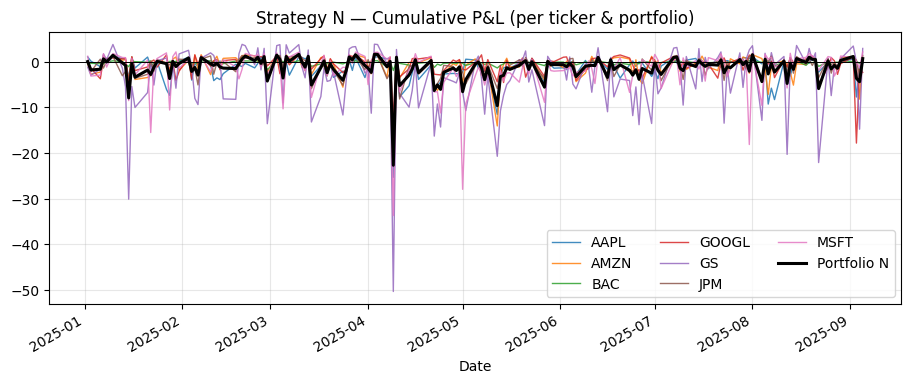

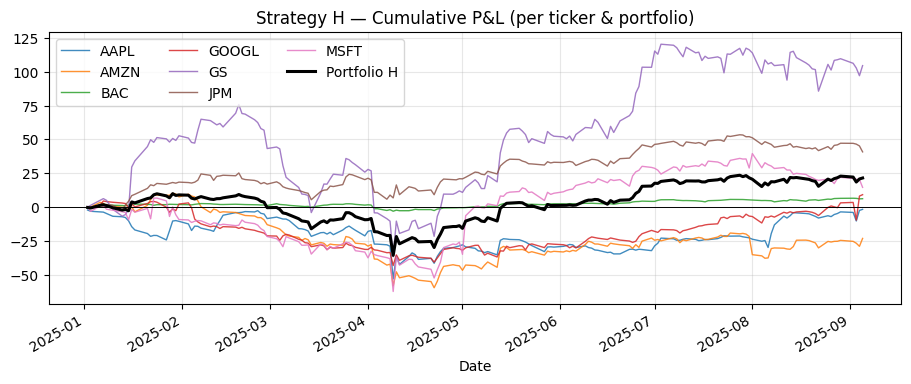

In [ ]:
def pnl_stats(pnl: pd.Series):
    pnl = pd.Series(pnl).dropna()
    if len(pnl) == 0:
        return pd.Series({"Mean":np.nan,"StDev":np.nan,"Sharpe(daily)":np.nan,"Sharpe(ann)":np.nan,"MaxDD":np.nan,"TotPnl":np.nan})
    mu  = pnl.mean()
    sd  = pnl.std()
    sharpe_d = mu/sd if sd>0 else np.nan
    sharpe_a = sharpe_d * np.sqrt(252)
    wealth = pnl.cumsum()
    dd = (wealth/wealth.cummax() - 1).min()  # drawdown on cumulative P&L
    return pd.Series({"Mean":mu,"StDev":sd,"Sharpe(daily)":sharpe_d,"Sharpe(ann)":sharpe_a,"MaxDD":dd,"TotPnl":pnl.sum()})

# Per-ticker table
per_ticker_opt = []
for t in opt_results:
    rowN = pnl_stats(opt_results[t]["N"]); rowH = pnl_stats(opt_results[t]["H"])
    rowN.name = (t,"N"); rowH.name = (t,"H")
    per_ticker_opt += [rowN, rowH]
per_ticker_opt = pd.concat(per_ticker_opt, axis=1).T

# Portfolio table
if not pnlN_df.empty:
    port_tbl = pd.concat({"Port_N": pnl_stats(port_pnl_N),
                          "Port_H": pnl_stats(port_pnl_H)}, axis=1).T
else:
    port_tbl = pd.DataFrame()

display(per_ticker_opt.style.format({"Mean":"{:.4f}","StDev":"{:.4f}","Sharpe(daily)":"{:.2f}",
                                     "Sharpe(ann)":"{:.2f}","MaxDD":"{:.2%}","TotPnl":"{:.2f}"}))

if not port_tbl.empty:
    display(port_tbl.style.format({"Mean":"{:.4f}","StDev":"{:.4f}","Sharpe(daily)":"{:.2f}",
                                   "Sharpe(ann)":"{:.2f}","MaxDD":"{:.2%}","TotPnl":"{:.2f}"}))

# Plots
if not pnlN_df.empty:
    ax = pnlN_df.cumsum().plot(figsize=(11,4), lw=1, alpha=.85)
    port_pnl_N.cumsum().plot(ax=ax, lw=2.2, color="k", label="Portfolio N")
    ax.set_title("Strategy N — Cumulative P&L (per ticker & portfolio)"); ax.axhline(0, color="k", lw=.7)
    ax.grid(alpha=.3); ax.legend(ncol=3); plt.show()

    ax = pnlH_df.cumsum().plot(figsize=(11,4), lw=1, alpha=.85)
    port_pnl_H.cumsum().plot(ax=ax, lw=2.2, color="k", label="Portfolio H")
    ax.set_title("Strategy H — Cumulative P&L (per ticker & portfolio)"); ax.axhline(0, color="k", lw=.7)
    ax.grid(alpha=.3); ax.legend(ncol=3); plt.show()


# 6.6 Weekly re-hedge sensitivity

In [ ]:
HEDGE_FREQ = "W"   # then re-run 6.3 onwards


# 6.7 Risk-parity weighting for the option P&L portfolio

# 6.7.1 Helpers (rolling vol, weights, portfolio construction)

In [ ]:
# knobs
RP_ROLL_WIN = 63          # ~3 months of trading days
VOL_FLOOR   = 1e-8        # avoid div/0
MIN_TICKERS = 2           # require at least this many active names to form the portfolio on a day

def daily_vol(x: pd.Series) -> float:
    x = pd.Series(x).dropna()
    return float(x.std())

def inverse_vol_weights_from_cov(x: pd.DataFrame) -> np.ndarray:
    # simple inverse of per-name vol (diagonal) normalized
    vols = x.std().replace(0, np.nan)
    inv  = 1.0 / vols
    inv  = inv.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    if inv.sum() <= 0:
        return np.ones(x.shape[1]) / x.shape[1]
    return (inv / inv.sum()).values

def rolling_inverse_vol_weights(df: pd.DataFrame, roll_win=RP_ROLL_WIN) -> pd.DataFrame:
    """
    For each date t, compute weights ~ 1/vol over the trailing [t-roll_win, t-1].
    If fewer than MIN_TICKERS have valid vol, fallback to equal weight over available names.
    Returns a DataFrame of weights aligned to df.index/columns.
    """
    w_list = []
    cols = df.columns
    for idx in range(len(df.index)):
        d = df.index[idx]
        start = max(0, idx - roll_win)
        hist = df.iloc[start:idx]  # strictly past data
        if len(hist) < max(10, roll_win//4):  # need some history
            w_list.append(pd.Series(0.0, index=cols))
            continue
        vols = hist.std()
        vols = vols.replace(0, np.nan)
        active = vols.dropna().index
        if len(active) < MIN_TICKERS:
            w = pd.Series(0.0, index=cols)
        else:
            inv = 1.0 / vols.loc[active].clip(lower=VOL_FLOOR)
            w_active = inv / inv.sum()
            w = pd.Series(0.0, index=cols)
            w.loc[w_active.index] = w_active.values
        w_list.append(w)
    W = pd.DataFrame(w_list, index=df.index, columns=cols)
    return W

def apply_weights_to_pnl(df_pnl: pd.DataFrame, W: pd.DataFrame) -> pd.Series:
    """
    Multiply day-t weights by day-t P&Ls. If a name has NaN P&L on a day, treat as 0 (no position).
    """
    X = df_pnl.fillna(0.0).align(W.fillna(0.0), join="inner", axis=0)[0]
    W = W.reindex_like(X).fillna(0.0)
    port = (W.values * X.values).sum(axis=1)
    return pd.Series(port, index=X.index)


# 6.7.2 Static RP (estimated on IS) & Rolling RP (estimated OOS, trailing window)

In [ ]:
def static_inverse_vol_weights_from_IS(pnl_df: pd.DataFrame, is_end: pd.Timestamp) -> pd.Series:
    is_slice = pnl_df.loc[:str(is_end)].dropna(how="all")
    if is_slice.empty:
        # fallback equal weight if no IS P&L (e.g. options only OOS)
        return pd.Series(np.ones(pnl_df.shape[1]) / pnl_df.shape[1], index=pnl_df.columns)
    vols = is_slice.std()
    vols = vols.replace(0, np.nan)
    inv  = (1.0 / vols).replace([np.inf, -np.inf], np.nan).fillna(0.0)
    if inv.sum() == 0:
        return pd.Series(np.ones(len(inv)) / len(inv), index=inv.index)
    return inv / inv.sum()

# Build RP portfolios for Strategy N and H
results_rp = {}

for name, df in [("N", pnlN_df), ("H", pnlH_df)]:
    if df.empty:
        print(f"[{name}] Empty P&L matrix — skip RP.")
        continue

    # 1) Static inverse-vol weights from IS (clip to OOS columns present)
    w_static = static_inverse_vol_weights_from_IS(df, IN_END)
    w_static = w_static.reindex(df.columns).fillna(0.0)
    port_static = (df.fillna(0.0).values @ w_static.values)
    port_static = pd.Series(port_static, index=df.index, name=f"Port_{name}_RP_static")

    # 2) Rolling inverse-vol weights (OOS, trailing window)
    W_roll = rolling_inverse_vol_weights(df, roll_win=RP_ROLL_WIN)
    port_roll = apply_weights_to_pnl(df, W_roll)
    port_roll.name = f"Port_{name}_RP_roll"

    results_rp[name] = {
        "w_static": w_static,
        "W_roll":   W_roll,
        "port_static": port_static,
        "port_roll":   port_roll
    }

# Peek at last static weights
for k,v in results_rp.items():
    print(f"\n[{k}] Static RP weights (IS est.):")
    display(v["w_static"].to_frame(name="weight").T)



[N] Static RP weights (IS est.):


,AAPL,AMZN,BAC,GOOGL,GS,JPM,MSFT
weight,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857



[H] Static RP weights (IS est.):


,AAPL,AMZN,BAC,GOOGL,GS,JPM,MSFT
weight,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857


# 6.7.3 Compare Equal-Weight vs Risk-Parity portfolios

In [ ]:
def pnl_stats(pnl: pd.Series):
    pnl = pd.Series(pnl).dropna()
    if len(pnl) == 0:
        return pd.Series({"Mean":np.nan,"StDev":np.nan,"Sharpe(daily)":np.nan,"Sharpe(ann)":np.nan,"MaxDD":np.nan,"TotPnl":np.nan})
    mu  = pnl.mean()
    sd  = pnl.std()
    sharpe_d = mu/sd if sd>0 else np.nan
    sharpe_a = sharpe_d * np.sqrt(252)
    wealth = pnl.cumsum()
    dd = (wealth/wealth.cummax() - 1).min()
    return pd.Series({"Mean":mu,"StDev":sd,"Sharpe(daily)":sharpe_d,"Sharpe(ann)":sharpe_a,"MaxDD":dd,"TotPnl":pnl.sum()})

tables = []
plots  = []

if not pnlN_df.empty:
    # Equal-weight already computed earlier as port_pnl_N / port_pnl_H
    tbl_N = pd.concat({
        "N_EQ":  pnl_stats(port_pnl_N),
        "N_RP_static": pnl_stats(results_rp["N"]["port_static"]),
        "N_RP_roll":   pnl_stats(results_rp["N"]["port_roll"]),
    }, axis=1).T
    tables.append(tbl_N)

if not pnlH_df.empty:
    tbl_H = pd.concat({
        "H_EQ":  pnl_stats(port_pnl_H),
        "H_RP_static": pnl_stats(results_rp["H"]["port_static"]),
        "H_RP_roll":   pnl_stats(results_rp["H"]["port_roll"]),
    }, axis=1).T
    tables.append(tbl_H)

if tables:
    comp_tbl = pd.concat(tables, axis=0)
    display(comp_tbl.style.format({
        "Mean":"{:.5f}","StDev":"{:.5f}",
        "Sharpe(daily)":"{:.2f}","Sharpe(ann)":"{:.2f}",
        "MaxDD":"{:.2%}","TotPnl":"{:.2f}"
    }))
else:
    print("No option portfolio P&L available to compare weights.")


,Mean,StDev,Sharpe(daily),Sharpe(ann),MaxDD,TotPnl
N_EQ,0.00409,3.70012,0.00,0.02,-3827.17%,0.69
N_RP_static,0.00409,3.70012,0.00,0.02,-3827.17%,0.69
N_RP_roll,-0.01246,1.77356,-0.01,-0.11,-inf%,-2.11
H_EQ,0.12675,2.77824,0.05,0.72,-463.00%,21.42
H_RP_static,0.12675,2.77824,0.05,0.72,-463.00%,21.42
H_RP_roll,0.03802,1.40444,0.03,0.43,-inf%,6.42


# 6.7.4 Plots - cumulative P&L (EQ vs RP)

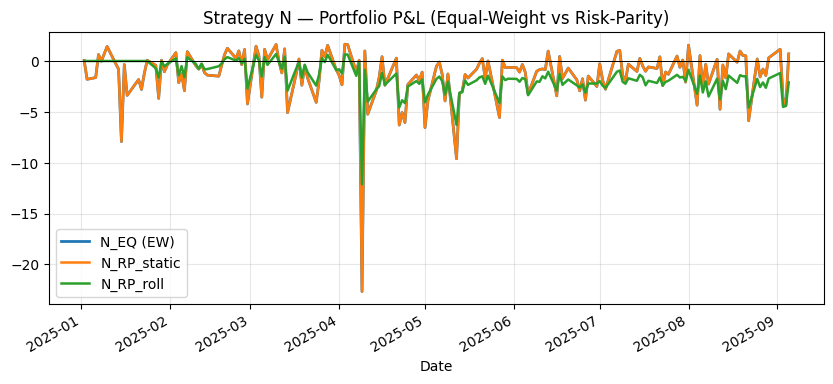

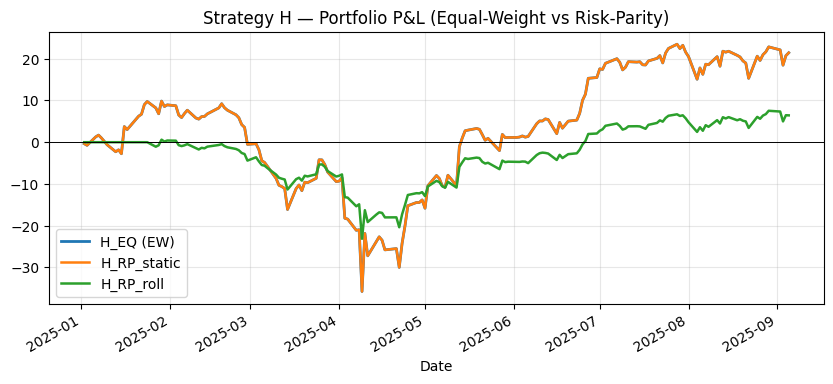

In [ ]:
if not pnlN_df.empty:
    ax = port_pnl_N.cumsum().plot(figsize=(10,4), lw=2, label="N_EQ (EW)")
    results_rp["N"]["port_static"].cumsum().plot(ax=ax, lw=1.8, label="N_RP_static")
    results_rp["N"]["port_roll"].cumsum().plot(ax=ax, lw=1.8, label="N_RP_roll")
    ax.set_title("Strategy N — Portfolio P&L (Equal-Weight vs Risk-Parity)")
    ax.axhline(0, color="k", lw=.7); ax.grid(alpha=.3); ax.legend(); plt.show()

if not pnlH_df.empty:
    ax = port_pnl_H.cumsum().plot(figsize=(10,4), lw=2, label="H_EQ (EW)")
    results_rp["H"]["port_static"].cumsum().plot(ax=ax, lw=1.8, label="H_RP_static")
    results_rp["H"]["port_roll"].cumsum().plot(ax=ax, lw=1.8, label="H_RP_roll")
    ax.set_title("Strategy H — Portfolio P&L (Equal-Weight vs Risk-Parity)")
    ax.axhline(0, color="k", lw=.7); ax.grid(alpha=.3); ax.legend(); plt.show()


# Part III - CoVaR on real data

# 1.1 Pick driver (X) and target (Y)

In [48]:
# Choose a pair; fall back to first two available tickers
A = "JPM" if "JPM" in ret.columns else ret.columns[0]     # driver (X)
B = "GS"  if "GS"  in ret.columns else ret.columns[1]     # target (Y)

# System portfolio (equal-weight of all names in your universe)
mkt = ret.mean(axis=1)   # crude "system" factor

# Split IS / OOS using the already defined dates
rA_is  = ret[A].loc[str(IN_START):str(IN_END)].dropna()
rB_is  = ret[B].loc[str(IN_START):str(IN_END)].dropna()
mkt_is = mkt   .loc[str(IN_START):str(IN_END)].dropna()

rA_oos  = ret[A].loc[str(OOS_START):str(OOS_END)].dropna()
rB_oos  = ret[B].loc[str(OOS_START):str(OOS_END)].dropna()
mkt_oos = mkt   .loc[str(OOS_START):str(OOS_END)].dropna()

print(f"IS obs: A={len(rA_is)}, B={len(rB_is)}, SYS={len(mkt_is)} | OOS obs: A={len(rA_oos)}, B={len(rB_oos)}")


IS obs: A=502, B=502, SYS=502 | OOS obs: A=169, B=169


# 1.2 CoVaR utilities (historical band, kernel-weighted, QR decoupled)

In [49]:
import numpy as np
from sklearn.linear_model import QuantileRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

ALPHA = 0.05

def VaR(x, alpha=ALPHA):
    x = np.asarray(x)
    return float(np.quantile(x, alpha))

def hist_band_covar(X, Y, alpha=ALPHA, bw_frac=0.15):
    """Condition on X within a band around VaR_X; bw_frac is % of |X - VaR| tolerated (data-adaptive)."""
    X = np.asarray(X); Y = np.asarray(Y)
    var_x = VaR(X, alpha)
    scale = np.nanmedian(np.abs(X - np.nanmedian(X))) + 1e-12  # robust MAD-like scale
    tol   = max(1e-8, bw_frac * scale)
    mask  = np.abs(X - var_x) <= tol
    if mask.sum() < 30:
        # widen band if too few obs
        tol *= 1.5
        mask = np.abs(X - var_x) <= tol
    covar = float(np.quantile(Y[mask], alpha)) if mask.sum() else np.nan
    return covar, var_x, int(mask.sum()), tol

# Gaussian-kernel CoVaR with simple Silverman bandwidth
def kernel_covar(X, Y, alpha=ALPHA, h=None):
    X = np.asarray(X); Y = np.asarray(Y)
    var_x = VaR(X, alpha)
    if h is None:
        s = np.std(X, ddof=1); n = len(X)
        h = max(1e-6, 1.06 * s * (n ** (-1/5)))
    w = np.exp(-0.5*((X - var_x)/h)**2) / np.sqrt(2*np.pi)
    if np.allclose(w.sum(), 0):
        return np.nan, var_x, h
    # weighted alpha-quantile of Y
    order = np.argsort(Y); Ys, Ws = Y[order], w[order]
    cw = np.cumsum(Ws) / Ws.sum()
    idx = np.searchsorted(cw, alpha, side="left")
    return float(Ys[min(idx, len(Ys)-1)]), float(var_x), float(h)

# Decoupled quantile regression: learn Q_alpha(Y | features), then plug in X=VaR_X and a context value for other features
def decoupled_qr_covar(X, Y, Z=None, alpha=ALPHA, deg=1, context="cond_mean"):
    """
    X: driver series (e.g., -rA)
    Y: target loss (e.g., -rB or -mkt)
    Z: optional extra feature series (e.g., mkt or other factors)
    context: how to set non-X features at evaluation ("cond_mean" given X≈VaR_X, or "median")
    """
    df = pd.DataFrame({"X": X, "Y": Y})
    if Z is not None:
        if isinstance(Z, pd.Series):
            df["Z"] = Z.reindex(df.index)
        else:
            raise ValueError("Z must be a pandas Series aligned to X/Y")

    df = df.dropna()
    feats = ["X"] + (["Z"] if "Z" in df.columns else [])
    Xmat  = df[feats].values
    y     = df["Y"].values

    if deg == 1:
        model = QuantileRegressor(quantile=alpha, alpha=0.0, solver="highs")
    else:
        model = Pipeline([("poly", PolynomialFeatures(degree=deg, include_bias=False)),
                          ("qr", QuantileRegressor(quantile=alpha, alpha=0.0, solver="highs"))])
    model.fit(Xmat, y)

    var_x = VaR(df["X"].values, alpha)
    # choose context for other features
    ctx = {}
    if "Z" in df.columns:
        if context == "cond_mean":
            # use band around VaR_X to estimate E[Z | X≈VaR_X]
            cov, vx, used, tol = hist_band_covar(df["X"].values, df["Y"].values, alpha=alpha, bw_frac=0.15)
            mask = np.abs(df["X"].values - var_x) <= tol
            ctx["Z"] = float(np.mean(df.loc[mask, "Z"])) if mask.sum() else float(df["Z"].median())
        else:
            ctx["Z"] = float(df["Z"].median())

    x_eval = [var_x] + ([ctx["Z"]] if "Z" in df.columns else [])
    qhat = float(model.predict(np.array(x_eval).reshape(1, -1))[0])
    return qhat, var_x, feats, ctx


# 1.3 Define losses and estimate CoVaR (IS)

In [50]:
# Define daily losses
X_is_pair   = (-rA_is).align(-rB_is, join="inner")[0]   # align indices
Y_is_pair   = (-rB_is).reindex_like(X_is_pair)

X_is_sys    = (-rA_is).align(-mkt_is, join="inner")[0]
Y_is_sys    = (-mkt_is).reindex_like(X_is_sys)

# Unconditional VaR of Y (for ΔCoVaR)
VaR_Y_pair = VaR(Y_is_pair, ALPHA)
VaR_Y_sys  = VaR(Y_is_sys , ALPHA)

# Pair (A -> B)
cov_hist_pair, varx_pair, used_pair, tol_pair = hist_band_covar(X_is_pair, Y_is_pair, alpha=ALPHA, bw_frac=0.15)
cov_ker_pair,  varx2, h_pair = kernel_covar(X_is_pair, Y_is_pair, alpha=ALPHA)
cov_qr_pair,   varx3, feats_pair, ctx_pair = decoupled_qr_covar(X_is_pair, Y_is_pair, Z=None, alpha=ALPHA, deg=1)

# System (A -> SYS) with market context as extra feature
cov_hist_sys, varx_sys, used_sys, tol_sys = hist_band_covar(X_is_sys, Y_is_sys, alpha=ALPHA, bw_frac=0.15)
cov_ker_sys,  _,       h_sys = kernel_covar(X_is_sys, Y_is_sys, alpha=ALPHA)
cov_qr_sys,   _,       feats_sys, ctx_sys = decoupled_qr_covar(X_is_sys, Y_is_sys, Z=None, alpha=ALPHA, deg=1)  # if you want Z=mkt, pass Z=mkt_is

summary = pd.DataFrame({
    "Case": ["A→B (pair)","A→B (pair)","A→B (pair)","A→SYS (system)","A→SYS (system)","A→SYS (system)"],
    "Estimator": ["Historical Band","Kernel","Quantile-Regression",
                  "Historical Band","Kernel","Quantile-Regression"],
    "VaR_X": [varx_pair, varx2, varx3, varx_sys, varx_sys, varx_sys],
    "CoVaR": [cov_hist_pair, cov_ker_pair, cov_qr_pair, cov_hist_sys, cov_ker_sys, cov_qr_sys],
    "VaR_Y (uncond.)": [VaR_Y_pair]*3 + [VaR_Y_sys]*3
})
summary["ΔCoVaR = CoVaR − VaR_Y"] = summary["CoVaR"] - summary["VaR_Y (uncond.)"]
display(summary.style.format({"VaR_X":"{:.4f}","CoVaR":"{:.4f}","VaR_Y (uncond.)":"{:.4f}","ΔCoVaR = CoVaR − VaR_Y":"{:.4f}"}))


,Case,Estimator,VaR_X,CoVaR,VaR_Y (uncond.),ΔCoVaR = CoVaR − VaR_Y
0,A→B (pair),Historical Band,-0.0193,-0.0375,-0.0241,-0.0134
1,A→B (pair),Kernel,-0.0193,-0.0355,-0.0241,-0.0114
2,A→B (pair),Quantile-Regression,-0.0193,-0.0326,-0.0241,-0.0085
3,A→SYS (system),Historical Band,-0.0193,-0.0238,-0.0171,-0.0067
4,A→SYS (system),Kernel,-0.0193,-0.0235,-0.0171,-0.0065
5,A→SYS (system),Quantile-Regression,-0.0193,-0.0215,-0.0171,-0.0044


# 1.4 Rolling CoVaR time-series (OOS) - kernel estimator

In [51]:
def rolling_kernel_covar_series(X: pd.Series, Y: pd.Series, alpha=ALPHA, win=252):
    X = pd.Series(X).dropna()
    Y = pd.Series(Y).dropna()
    idx = X.index.intersection(Y.index)
    X = X.loc[idx]; Y = Y.loc[idx]
    if len(idx) < win + 5:
        # not enough data for rolling window
        return pd.Series(dtype="float64", name="CoVaR"), pd.Series(dtype="float64", name="VaR_X")

    covs, varxs, dates = [], [], []
    for i in range(win, len(idx)):
        Xw = X.iloc[i-win:i].values
        Yw = Y.iloc[i-win:i].values
        cov, varx, h = kernel_covar(Xw, Yw, alpha=alpha, h=None)
        # Ensure numeric (np.nan allowed)
        covs.append(float(cov) if cov is not None else np.nan)
        varxs.append(float(varx) if varx is not None else np.nan)
        dates.append(idx[i])
    covs = pd.Series(covs, index=dates, name="CoVaR").astype("float64")
    varxs= pd.Series(varxs, index=dates, name="VaR_X").astype("float64")
    return covs, varxs

def rolling_VaR(y: pd.Series, alpha=ALPHA, win=252):
    y = pd.Series(y).dropna()
    if len(y) < win + 5:
        return pd.Series(dtype="float64")
    out, dates = [], []
    for i in range(win, len(y)):
        w = y.iloc[i-win:i].values
        out.append(float(np.quantile(w, alpha)))
        dates.append(y.index[i])
    return pd.Series(out, index=dates, name=f"VaR_{alpha:.2f}").astype("float64")


In [52]:
# Pick window that fits OOS sample (use ~min(252, 0.8 * length))
eff_len_pair = len(X_oos_pair.index.intersection(Y_oos_pair.index))
eff_len_sys  = len(X_oos_sys.index.intersection(Y_oos_sys.index))
ROLL_WIN = max(126, min(252, int(0.8 * min(eff_len_pair, eff_len_sys))))  # 6–12 months

cov_pair_ts, varx_pair_ts = rolling_kernel_covar_series(X_oos_pair, Y_oos_pair, alpha=ALPHA, win=ROLL_WIN)
cov_sys_ts,  varx_sys_ts  = rolling_kernel_covar_series(X_oos_sys,  Y_oos_sys,  alpha=ALPHA, win=ROLL_WIN)

VaR_Y_pair_ts = rolling_VaR(Y_oos_pair, alpha=ALPHA, win=ROLL_WIN)
VaR_Y_sys_ts  = rolling_VaR(Y_oos_sys,  alpha=ALPHA, win=ROLL_WIN)

def clean_numeric(s):
    return (pd.to_numeric(s, errors="coerce")
              .replace([np.inf, -np.inf], np.nan)
              .dropna())

cov_pair_ts_c = clean_numeric(cov_pair_ts)
VaR_Y_pair_ts_c = clean_numeric(VaR_Y_pair_ts)
cov_sys_ts_c  = clean_numeric(cov_sys_ts)
VaR_Y_sys_ts_c= clean_numeric(VaR_Y_sys_ts)


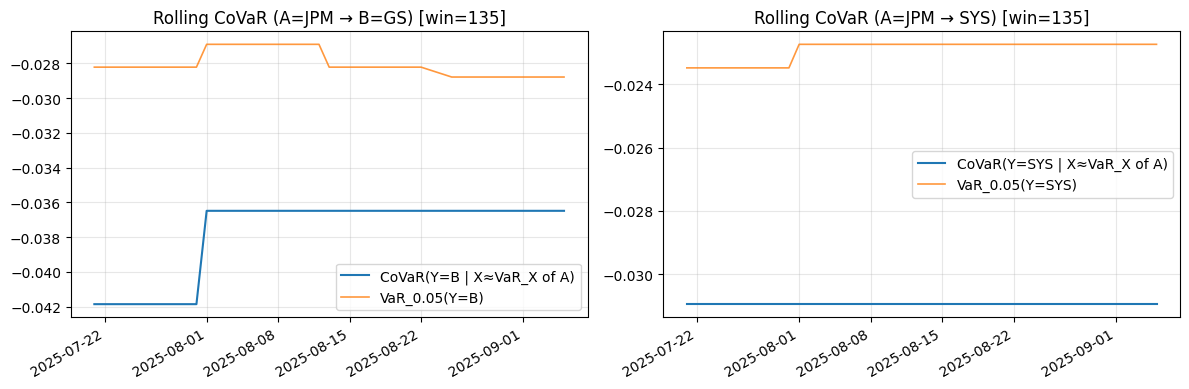

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

if len(cov_pair_ts_c) and len(VaR_Y_pair_ts_c):
    cov_pair_ts_c.plot(ax=ax[0], lw=1.5, label="CoVaR(Y=B | X≈VaR_X of A)")
    VaR_Y_pair_ts_c.reindex_like(cov_pair_ts_c, method="nearest").plot(ax=ax[0], lw=1.2, alpha=.8, label=f"VaR_{ALPHA:.2f}(Y=B)")
    ax[0].set_title(f"Rolling CoVaR (A={A} → B={B}) [win={ROLL_WIN}]")
    ax[0].grid(alpha=.3); ax[0].legend()
else:
    ax[0].text(0.5, 0.5, "No numeric data to plot (pair)", ha="center"); ax[0].axis("off")

if len(cov_sys_ts_c) and len(VaR_Y_sys_ts_c):
    cov_sys_ts_c.plot(ax=ax[1], lw=1.5, label="CoVaR(Y=SYS | X≈VaR_X of A)")
    VaR_Y_sys_ts_c.reindex_like(cov_sys_ts_c, method="nearest").plot(ax=ax[1], lw=1.2, alpha=.8, label=f"VaR_{ALPHA:.2f}(Y=SYS)")
    ax[1].set_title(f"Rolling CoVaR (A={A} → SYS) [win={ROLL_WIN}]")
    ax[1].grid(alpha=.3); ax[1].legend()
else:
    ax[1].text(0.5, 0.5, "No numeric data to plot (system)", ha="center"); ax[1].axis("off")

plt.tight_layout(); plt.show()


# 1.5 Rebuild returns with longer historical data

In [54]:
# knobs
YEARS_TOTAL = 15      # total lookback
YEARS_OOS   = 10      # last 10y = OOS
YEARS_IS    = YEARS_TOTAL - YEARS_OOS  # IS = 5y
ALPHA       = 0.05
ROLL_WIN    = 252     # ~1y rolling window

import datetime as dt, numpy as np, pandas as pd, yfinance as yf
pd.options.display.float_format = "{:,.6f}".format

# Use our universe; ensure pair is included here
UNIVERSE = list(ret.columns) if 'ret' in globals() else ["AAPL","MSFT","AMZN","GOOGL","META", "JPM","GS","BAC"]

END = dt.date.today()
START = END - pd.DateOffset(years=YEARS_TOTAL)
print("Downloading:", UNIVERSE, "from:", START.date(), "to:", END)

px_long = yf.download(UNIVERSE, start=str(START.date()), end=str(END), auto_adjust=True, progress=False)["Close"]
if isinstance(px_long, pd.Series): px_long = px_long.to_frame()
px_long = px_long.dropna(how="all").ffill().dropna(axis=1, how="all")

# daily simple returns → use LOSSES = -returns for CoVaR
ret_long = px_long.pct_change().dropna(how="all")
print("Shapes: px_long", px_long.shape, "ret_long", ret_long.shape)

# Split IS/OOS
cut_is_end  = (END - pd.DateOffset(years=YEARS_OOS))
cut_oos_beg = cut_is_end
print("IS = [", START.date(), ",", cut_is_end.date(), ")  |  OOS = [", cut_oos_beg.date(), ",", END, "]")

ret_is  = ret_long.loc[:str(cut_is_end.date())].dropna()
ret_oos = ret_long.loc[str(cut_oos_beg.date()):].dropna()

# Select A,B and system factor
A = "JPM" if "JPM" in ret_long.columns else ret_long.columns[0]
B = "GS"  if "GS"  in ret_long.columns else ret_long.columns[min(1, len(ret_long.columns)-1)]
mkt = ret_long.mean(axis=1)  # equal-weight system proxy

print(f"Using A={A} (driver), B={B} (target), system=EW({len(ret_long.columns)} names)")


Downloading: ['AAPL', 'AMZN', 'BAC', 'GOOGL', 'GS', 'JPM', 'MSFT'] from: 2010-09-06 to: 2025-09-06
Shapes: px_long (3773, 7) ret_long (3772, 7)
IS = [ 2010-09-06 , 2015-09-06 )  |  OOS = [ 2015-09-06 , 2025-09-06 ]
Using A=JPM (driver), B=GS (target), system=EW(7 names)


# 1.6 CoVar helpers

In [55]:
import numpy as np

def VaR(x, alpha=ALPHA):
    x = np.asarray(pd.Series(x).dropna())
    return float(np.quantile(x, alpha)) if x.size else np.nan

def kernel_covar(X, Y, alpha=ALPHA, h=None):
    X = np.asarray(pd.Series(X).dropna())
    Y = np.asarray(pd.Series(Y).dropna())
    n = min(len(X), len(Y))
    if n == 0: return np.nan, np.nan, np.nan
    var_x = VaR(X, alpha)
    if not np.isfinite(var_x): return np.nan, np.nan, np.nan
    if h is None:
        s = X.std(ddof=1) if X.std(ddof=1) > 0 else 1.0
        h = max(1e-6, 1.06 * s * (n ** (-1/5)))  # Silverman
    w = np.exp(-0.5*((X - var_x)/h)**2) / np.sqrt(2*np.pi)
    if w.sum() <= 0 or np.all(~np.isfinite(w)): return np.nan, var_x, h
    # weighted alpha-quantile of Y
    order = np.argsort(Y); Ys, Ws = Y[order], w[order]
    Ws = np.where(np.isfinite(Ws), Ws, 0.0)
    cw = np.cumsum(Ws) / (Ws.sum() if Ws.sum()>0 else 1.0)
    idx = np.searchsorted(cw, alpha, side="left")
    idx = np.clip(idx, 0, len(Ys)-1)
    return float(Ys[idx]), float(var_x), float(h)

def rolling_kernel_covar_series(X: pd.Series, Y: pd.Series, alpha=ALPHA, win=252):
    X = pd.Series(X).dropna(); Y = pd.Series(Y).dropna()
    idx = X.index.intersection(Y.index)
    X = X.loc[idx]; Y = Y.loc[idx]
    if len(idx) < win + 20:
        return pd.Series(dtype="float64", name="CoVaR"), pd.Series(dtype="float64", name="VaR_X")
    covs, varxs, dates = [], [], []
    for i in range(win, len(idx)):
        Xw = X.iloc[i-win:i].values
        Yw = Y.iloc[i-win:i].values
        cov, varx, _ = kernel_covar(Xw, Yw, alpha=alpha, h=None)
        covs.append(np.nan if not np.isfinite(cov) else float(cov))
        varxs.append(np.nan if not np.isfinite(varx) else float(varx))
        dates.append(idx[i])
    return (pd.Series(covs, index=dates, name="CoVaR").astype("float64"),
            pd.Series(varxs, index=dates, name="VaR_X").astype("float64"))

def rolling_VaR(y: pd.Series, alpha=ALPHA, win=252):
    y = pd.Series(y).dropna()
    if len(y) < win + 20: return pd.Series(dtype="float64", name=f"VaR_{alpha:.2f}")
    out, dates = [], []
    for i in range(win, len(y)):
        w = y.iloc[i-win:i].values
        out.append(float(np.quantile(w, alpha)))
        dates.append(y.index[i])
    return pd.Series(out, index=dates, name=f"VaR_{alpha:.2f}").astype("float64")


# 1.7 Build losses and run rolling CoVaR (10y OOS, window = 252)

In [56]:
# Losses = -returns
XA_oos_pair = (-ret_oos[A]).align(-ret_oos[B], join="inner")[0]
YB_oos_pair = (-ret_oos[B]).reindex_like(XA_oos_pair)

XA_oos_sys  = (-ret_oos[A]).align(-mkt, join="inner")[0]
YS_oos_sys  = (-mkt).reindex_like(XA_oos_sys)

cov_pair_ts, varx_pair_ts = rolling_kernel_covar_series(XA_oos_pair, YB_oos_pair, alpha=ALPHA, win=ROLL_WIN)
cov_sys_ts,  varx_sys_ts  = rolling_kernel_covar_series(XA_oos_sys,  YS_oos_sys,  alpha=ALPHA, win=ROLL_WIN)

VaR_Y_pair_ts = rolling_VaR(YB_oos_pair, alpha=ALPHA, win=ROLL_WIN)
VaR_Y_sys_ts  = rolling_VaR(YS_oos_sys,  alpha=ALPHA, win=ROLL_WIN)

def clean(s): return (pd.to_numeric(s, errors="coerce")
                        .replace([np.inf, -np.inf], np.nan).dropna())
cov_pair_ts_c  = clean(cov_pair_ts)
VaR_Y_pair_c   = clean(VaR_Y_pair_ts)
cov_sys_ts_c   = clean(cov_sys_ts)
VaR_Y_sys_c    = clean(VaR_Y_sys_ts)


# 1.8 Plot CoVaR vs VaR and ΔCoVaR


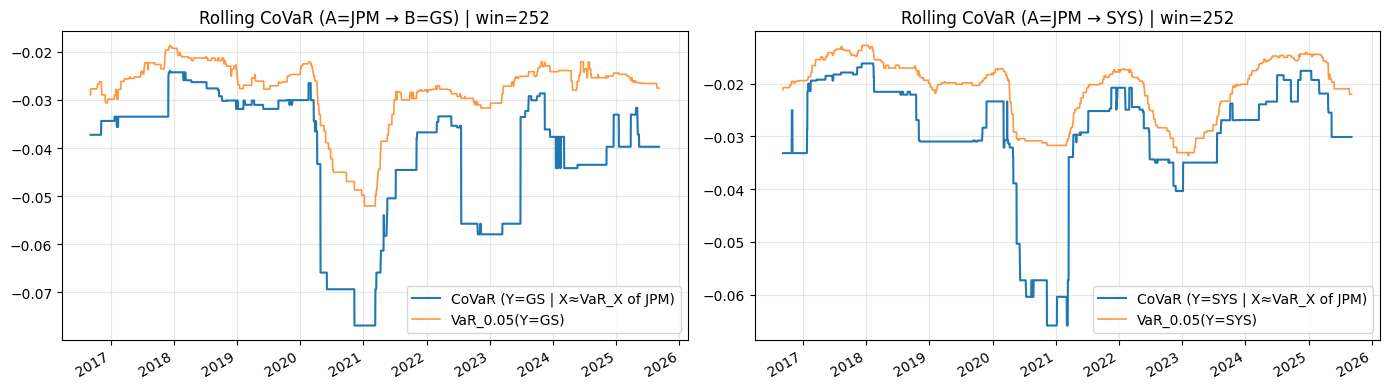

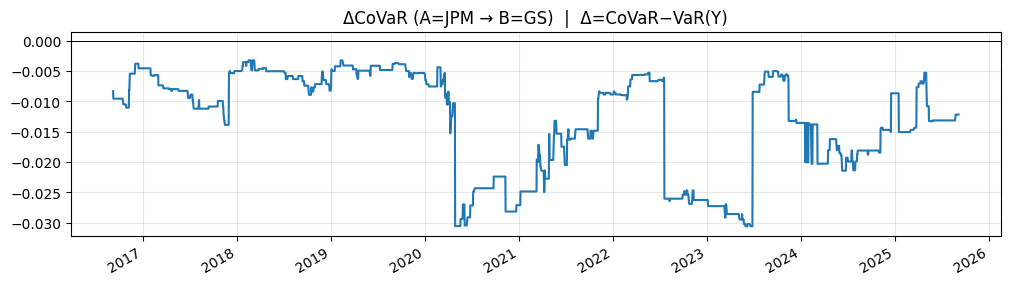

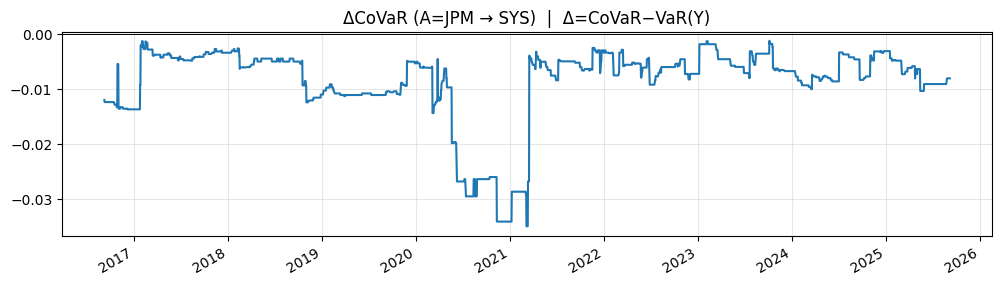

In [57]:
import matplotlib.pyplot as plt

# CoVaR vs VaR
fig, ax = plt.subplots(1,2, figsize=(14,4))
if len(cov_pair_ts_c) and len(VaR_Y_pair_c):
    cov_pair_ts_c.plot(ax=ax[0], lw=1.5, label=f"CoVaR (Y={B} | X≈VaR_X of {A})")
    VaR_Y_pair_c.reindex_like(cov_pair_ts_c, method="nearest").plot(ax=ax[0], lw=1.2, alpha=.8, label=f"VaR_{ALPHA:.2f}(Y={B})")
    ax[0].set_title(f"Rolling CoVaR (A={A} → B={B}) | win={ROLL_WIN}"); ax[0].grid(alpha=.3); ax[0].legend()
else:
    ax[0].text(0.5,0.5,"Insufficient numeric data (pair)",ha="center"); ax[0].axis("off")

if len(cov_sys_ts_c) and len(VaR_Y_sys_c):
    cov_sys_ts_c.plot(ax=ax[1], lw=1.5, label=f"CoVaR (Y=SYS | X≈VaR_X of {A})")
    VaR_Y_sys_c.reindex_like(cov_sys_ts_c, method="nearest").plot(ax=ax[1], lw=1.2, alpha=.8, label=f"VaR_{ALPHA:.2f}(Y=SYS)")
    ax[1].set_title(f"Rolling CoVaR (A={A} → SYS) | win={ROLL_WIN}"); ax[1].grid(alpha=.3); ax[1].legend()
else:
    ax[1].text(0.5,0.5,"Insufficient numeric data (system)",ha="center"); ax[1].axis("off")
plt.tight_layout(); plt.show()

# ΔCoVaR = CoVaR − VaR(Y)
if len(cov_pair_ts_c) and len(VaR_Y_pair_c):
    delta_pair = (cov_pair_ts_c - VaR_Y_pair_c.reindex_like(cov_pair_ts_c, method="nearest")).dropna()
    delta_pair.plot(figsize=(12,3), title=f"ΔCoVaR (A={A} → B={B})  |  Δ=CoVaR−VaR(Y)")
    plt.axhline(0, color="k", lw=.7); plt.grid(alpha=.3); plt.show()

if len(cov_sys_ts_c) and len(VaR_Y_sys_c):
    delta_sys = (cov_sys_ts_c - VaR_Y_sys_c.reindex_like(cov_sys_ts_c, method="nearest")).dropna()
    delta_sys.plot(figsize=(12,3), title=f"ΔCoVaR (A={A} → SYS)  |  Δ=CoVaR−VaR(Y)")
    plt.axhline(0, color="k", lw=.7); plt.grid(alpha=.3); plt.show()


# 1.9 Static CoVaR Summary (15y sample)

In [58]:
# pick losses again (full 15y daily returns)
XA_full_pair = (-ret_long[A]).align(-ret_long[B], join="inner")[0]
YB_full_pair = (-ret_long[B]).reindex_like(XA_full_pair)

XA_full_sys  = (-ret_long[A]).align(-mkt, join="inner")[0]
YS_full_sys  = (-mkt).reindex_like(XA_full_sys)

# unconditional VaR(Y)
VaR_Y_pair_full = VaR(YB_full_pair, ALPHA)
VaR_Y_sys_full  = VaR(YS_full_sys,  ALPHA)

# Historical Band (pair & sys)
cov_hist_pair, varx_pair, used_pair, tol_pair = hist_band_covar(XA_full_pair, YB_full_pair, alpha=ALPHA, bw_frac=0.15)
cov_hist_sys,  varx_sys,  used_sys,  tol_sys  = hist_band_covar(XA_full_sys,  YS_full_sys,  alpha=ALPHA, bw_frac=0.15)

# Kernel (Silverman bandwidth)
cov_ker_pair,  varx2, h_pair = kernel_covar(XA_full_pair, YB_full_pair, alpha=ALPHA)
cov_ker_sys,   varx4, h_sys  = kernel_covar(XA_full_sys,  YS_full_sys,  alpha=ALPHA)

# Quantile Regression (linear, deg=1)
cov_qr_pair, varx3, feats_pair, ctx_pair = decoupled_qr_covar(XA_full_pair, YB_full_pair, Z=None, alpha=ALPHA, deg=1)
cov_qr_sys,  varx5, feats_sys, ctx_sys   = decoupled_qr_covar(XA_full_sys,  YS_full_sys,  Z=None, alpha=ALPHA, deg=1)

# summary table
summary_full = pd.DataFrame({
    "Case": ["A→B (pair)"]*3 + ["A→SYS (system)"]*3,
    "Estimator": ["Historical Band","Kernel","Quantile-Regression"]*2,
    "VaR_X": [varx_pair, varx2, varx3, varx_sys, varx4, varx5],
    "CoVaR": [cov_hist_pair, cov_ker_pair, cov_qr_pair, cov_hist_sys, cov_ker_sys, cov_qr_sys],
    "VaR_Y (uncond.)": [VaR_Y_pair_full]*3 + [VaR_Y_sys_full]*3
})
summary_full["ΔCoVaR = CoVaR − VaR_Y"] = summary_full["CoVaR"] - summary_full["VaR_Y (uncond.)"]

display(summary_full.style.format({
    "VaR_X":"{:.4f}",
    "CoVaR":"{:.4f}",
    "VaR_Y (uncond.)":"{:.4f}",
    "ΔCoVaR = CoVaR − VaR_Y":"{:.4f}"
}))


,Case,Estimator,VaR_X,CoVaR,VaR_Y (uncond.),ΔCoVaR = CoVaR − VaR_Y
0,A→B (pair),Historical Band,-0.0257,-0.0361,-0.0267,-0.0094
1,A→B (pair),Kernel,-0.0257,-0.0385,-0.0267,-0.0118
2,A→B (pair),Quantile-Regression,-0.0257,-0.0388,-0.0267,-0.0121
3,A→SYS (system),Historical Band,-0.0257,-0.0325,-0.0208,-0.0117
4,A→SYS (system),Kernel,-0.0257,-0.0321,-0.0208,-0.0113
5,A→SYS (system),Quantile-Regression,-0.0257,-0.0296,-0.0208,-0.0088


# 2.0 Bootstrap CIs for static CoVar

In [60]:
# Bootstrap CIs for static CoVaR
import numpy as np, pandas as pd
from sklearn.linear_model import QuantileRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
import math

# Preconditions
assert 'ret_long' in globals(), "ret_long not found. Run the long-history block first."
assert 'A' in globals() and 'B' in globals(), "A/B not set. Run the long-history block first."
assert 'mkt' in globals(), "mkt not set. Run the long-history block first."
ALPHA = ALPHA if 'ALPHA' in globals() else 0.05  # e.g., 0.05

# Full-sample daily losses (driver X, target Y)
XA_full_pair = (-ret_long[A]).align(-ret_long[B], join="inner")[0]
YB_full_pair = (-ret_long[B]).reindex_like(XA_full_pair)

XA_full_sys  = (-ret_long[A]).align(-mkt, join="inner")[0]
YS_full_sys  = (-mkt).reindex_like(XA_full_sys)

# Helpers
def _as_clean_array(x):
    """Series -> clean float array (dropna, finite)."""
    s = pd.Series(x).dropna()
    a = pd.to_numeric(s, errors="coerce").replace([np.inf, -np.inf], np.nan).dropna().values
    return a

def VaR(x, alpha=ALPHA):
    a = _as_clean_array(x)
    return float(np.quantile(a, alpha)) if a.size else np.nan

def hist_band_covar(X, Y, alpha=ALPHA, bw_frac=0.15):
    """
    Historical-band CoVaR:
      condition on X within a band around VaR_X; take α-quantile of Y in-band.
    bw_frac is data-adaptive tolerance based on robust scale (MAD-like).
    """
    Xs = pd.Series(X); Ys = pd.Series(Y)
    idx = Xs.dropna().index.intersection(Ys.dropna().index)
    if len(idx) < 60:
        return np.nan, np.nan, 0, np.nan
    Xv, Yv = Xs.loc[idx].values, Ys.loc[idx].values
    var_x = VaR(Xv, alpha)
    if not np.isfinite(var_x): return np.nan, np.nan, 0, np.nan
    med = np.nanmedian(Xv); scale = np.nanmedian(np.abs(Xv - med)) + 1e-12
    tol = max(1e-8, bw_frac * scale)
    mask = np.abs(Xv - var_x) <= tol
    if mask.sum() < 30:
        tol *= 1.5
        mask = np.abs(Xv - var_x) <= tol
    if mask.sum() == 0:
        return np.nan, var_x, 0, tol
    covar = float(np.quantile(Yv[mask], alpha))
    return covar, float(var_x), int(mask.sum()), float(tol)

def kernel_covar(X, Y, alpha=ALPHA, h=None):
    """
    Kernel-weighted CoVaR with Gaussian kernel around VaR_X.
    Silverman bandwidth if h=None.
    """
    Xs = pd.Series(X); Ys = pd.Series(Y)
    idx = Xs.dropna().index.intersection(Ys.dropna().index)
    if len(idx) < 60:
        return np.nan, np.nan, np.nan
    Xv, Yv = Xs.loc[idx].values, Ys.loc[idx].values
    var_x = VaR(Xv, alpha)
    if not np.isfinite(var_x): return np.nan, np.nan, np.nan
    n = len(Xv)
    if h is None:
        s = Xv.std(ddof=1) if Xv.std(ddof=1) > 0 else 1.0
        h = max(1e-6, 1.06 * s * (n ** (-1/5)))
    w = np.exp(-0.5*((Xv - var_x)/h)**2) / math.sqrt(2*np.pi)
    if not np.isfinite(w).any() or w.sum() <= 0:
        return np.nan, float(var_x), float(h)
    order = np.argsort(Yv); Ys = Yv[order]; Ws = w[order]
    Ws = np.where(np.isfinite(Ws), Ws, 0.0)
    sW = Ws.sum()
    if sW <= 0:
        return np.nan, float(var_x), float(h)
    cw = np.cumsum(Ws) / sW
    idx_q = np.searchsorted(cw, alpha, side="left")
    idx_q = np.clip(idx_q, 0, len(Ys)-1)
    return float(Ys[idx_q]), float(var_x), float(h)

def decoupled_qr_covar(X, Y, Z=None, alpha=ALPHA, deg=1):
    """
    Decoupled quantile-regression CoVaR:
      fit Q_alpha(Y | features). Evaluate at X=VaR_X and Z=median (or conditional mean if you extend).
    """
    df = pd.DataFrame({"X": X, "Y": Y})
    if Z is not None:
        if isinstance(Z, pd.Series):
            df["Z"] = Z.reindex(df.index)
        else:
            raise ValueError("Z must be a pandas Series aligned to X/Y")
    df = df.dropna()
    if len(df) < 60:
        return np.nan, np.nan, [], {}
    feats = ["X"] + (["Z"] if "Z" in df.columns else [])
    Xmat = df[feats].values; y = df["Y"].values
    if deg == 1:
        model = QuantileRegressor(quantile=alpha, alpha=0.0, solver="highs")
    else:
        model = Pipeline([("poly", PolynomialFeatures(degree=deg, include_bias=False)),
                          ("qr", QuantileRegressor(quantile=alpha, alpha=0.0, solver="highs"))])
    model.fit(Xmat, y)
    var_x = VaR(df["X"].values, alpha)
    x_eval = [var_x] + ([float(df["Z"].median())] if "Z" in df.columns else [])
    qhat = model.predict(np.array(x_eval, dtype=float).reshape(1, -1)).item()
    return float(qhat), float(var_x), feats, {}

# Moving-block bootstrap
def mbb_indices(T, L, B=300, rng=np.random.default_rng(2)):
    """
    Moving-block bootstrap indices: returns list of index arrays of length T.
    T: series length, L: block length, B: # resamples.
    """
    if T < L + 1:
        raise ValueError(f"T={T} is smaller than block length L={L}")
    n_blocks = int(np.ceil(T / L))
    starts = np.arange(0, T - L + 1)
    idx_sets = []
    for _ in range(B):
        picks = rng.choice(starts, size=n_blocks, replace=True)
        idx = np.concatenate([np.arange(s, s+L) for s in picks])[:T]
        idx_sets.append(idx)
    return idx_sets

def covar_hist_wrap(X, Y, alpha=ALPHA):   c, v, *_ = hist_band_covar(X, Y, alpha=alpha); return c, v
def covar_kernel_wrap(X, Y, alpha=ALPHA): c, v, _   = kernel_covar(X, Y, alpha=alpha);   return c, v
def covar_qr_wrap(X, Y, alpha=ALPHA):     c, v, *_  = decoupled_qr_covar(X, Y, Z=None, alpha=alpha, deg=1); return c, v

def bootstrap_covar_CI(X: pd.Series, Y: pd.Series, estimator="kernel", alpha=ALPHA,
                       B=300, L=20, rng=np.random.default_rng(3)):
    """
    Block-bootstrap CI for CoVaR and ΔCoVaR.
    Returns dict with point estimates and 90% CI.
    """
    df = pd.DataFrame({"X": X, "Y": Y}).dropna()
    Xv = df["X"].values; Yv = df["Y"].values; T = len(df)
    if T < max(200, 5*L):
        raise ValueError(f"Series too short for bootstrap (len={T}); try smaller L (e.g., 10) or use monthly data.")

    est_map = {"hist": covar_hist_wrap, "kernel": covar_kernel_wrap, "qr": covar_qr_wrap}
    if estimator not in est_map:
        raise ValueError("estimator must be one of: 'hist', 'kernel', 'qr'")
    est_fn = est_map[estimator]

    # Point estimates
    cov_pt, varx_pt = est_fn(Xv, Yv, alpha=alpha)
    varY_pt = VaR(Yv, alpha)
    dcov_pt = cov_pt - varY_pt

    # Bootstrap samples
    idx_sets = mbb_indices(T, L, B=B, rng=rng)
    cov_samps, dcov_samps = [], []
    for idx in idx_sets:
        Xb, Yb = Xv[idx], Yv[idx]
        cov_b, _ = est_fn(Xb, Yb, alpha=alpha)
        varY_b   = VaR(Yb, alpha)
        cov_samps.append(cov_b)
        dcov_samps.append(cov_b - varY_b)

    cov_samps  = np.array(cov_samps, dtype=float)
    dcov_samps = np.array(dcov_samps, dtype=float)

    def qnan(a, q): return float(np.nanpercentile(a, q))
    cov_lo, cov_hi   = qnan(cov_samps, 5),  qnan(cov_samps, 95)
    dcov_lo, dcov_hi = qnan(dcov_samps, 5), qnan(dcov_samps, 95)

    return {
        "CoVaR": cov_pt, "CoVaR_lo": cov_lo, "CoVaR_hi": cov_hi,
        "VaR_X": varx_pt, "VaR_Y": varY_pt,
        "ΔCoVaR": dcov_pt, "ΔCoVaR_lo": dcov_lo, "ΔCoVaR_hi": dcov_hi,
        "T": T, "B": B, "L": L
    }

# Run bootstrap for pair & system, three estimators
B = 300   # reps (can be increased)
L = 20    # block length (~1 trading month). test L in {10, 40} for robustness.

cases = {
    f"{A}→{B} (pair)": (XA_full_pair, YB_full_pair),
    f"{A}→SYS (system)": (XA_full_sys,  YS_full_sys)
}
estimators = {
    "Historical Band": "hist",
    "Kernel": "kernel",
    "Quantile Regression": "qr"
}

rows = []
for cname, (Xser, Yser) in cases.items():
    for ename, tag in estimators.items():
        try:
            res = bootstrap_covar_CI(Xser, Yser, estimator=tag, alpha=ALPHA, B=B, L=L)
            row = [
                cname, ename,
                res.get("VaR_X", np.nan), res.get("VaR_Y", np.nan),
                res.get("CoVaR", np.nan), res.get("CoVaR_lo", np.nan), res.get("CoVaR_hi", np.nan),
                res.get("ΔCoVaR", np.nan), res.get("ΔCoVaR_lo", np.nan), res.get("ΔCoVaR_hi", np.nan),
                res.get("T", np.nan), res.get("B", np.nan), res.get("L", np.nan)
            ]
        except Exception as e:
            # Keep row shape; store error in last column
            row = [cname, ename] + [np.nan]*10 + [f"{type(e).__name__}: {e}"]
        rows.append(row)

summary_full_ci = pd.DataFrame(rows, columns=[
    "Case","Estimator","VaR_X","VaR_Y",
    "CoVaR","CoVaR_lo","CoVaR_hi",
    "ΔCoVaR","ΔCoVaR_lo","ΔCoVaR_hi",
    "Obs","B","BlockL_or_Error"
])

fmt_cols = ["VaR_X","VaR_Y","CoVaR","CoVaR_lo","CoVaR_hi","ΔCoVaR","ΔCoVaR_lo","ΔCoVaR_hi"]
fmt_cols = [c for c in fmt_cols if c in summary_full_ci.columns]

def _fmt(x):
    try: return f"{float(x):.4f}"
    except Exception: return x

df_show = summary_full_ci.copy()
for c in fmt_cols:
    df_show[c] = df_show[c].apply(_fmt)

print(f"Static CoVaR@{int(ALPHA*100)}% with 90% Block-Bootstrap CIs (B={B}, L={L})")
display(df_show)


Static CoVaR@5% with 90% Block-Bootstrap CIs (B=300, L=20)


,Case,Estimator,VaR_X,VaR_Y,CoVaR,CoVaR_lo,CoVaR_hi,ΔCoVaR,ΔCoVaR_lo,ΔCoVaR_hi,Obs,B,BlockL_or_Error
0,JPM→300 (pair),Historical Band,-0.0257,-0.0267,-0.0361,-0.0505,-0.0277,-0.0094,-0.0244,-0.0015,3772,300,20
1,JPM→300 (pair),Kernel,-0.0257,-0.0267,-0.0385,-0.0446,-0.0354,-0.0118,-0.0167,-0.0085,3772,300,20
2,JPM→300 (pair),Quantile Regression,-0.0257,-0.0267,-0.0388,-0.0418,-0.0354,-0.0121,-0.0136,-0.0094,3772,300,20
3,JPM→SYS (system),Historical Band,-0.0257,-0.0208,-0.0325,-0.0389,-0.0265,-0.0117,-0.0182,-0.0059,3772,300,20
4,JPM→SYS (system),Kernel,-0.0257,-0.0208,-0.0321,-0.0344,-0.0293,-0.0113,-0.0132,-0.0092,3772,300,20
5,JPM→SYS (system),Quantile Regression,-0.0257,-0.0208,-0.0296,-0.0318,-0.0269,-0.0088,-0.0103,-0.0070,3772,300,20


# 2.1 Plot of ΔCoVaR

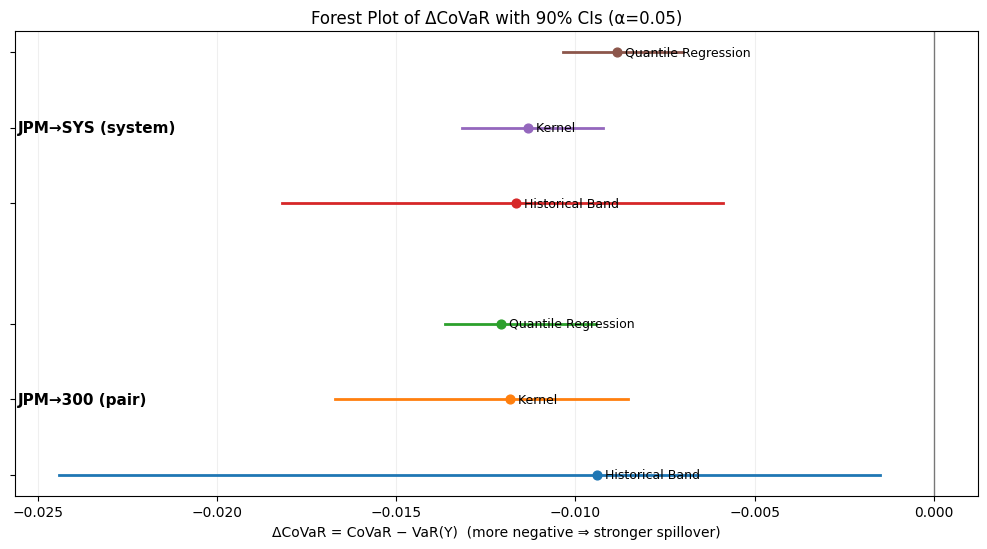

In [61]:
# Forest plot of ΔCoVaR with 90% CIs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Expect summary_full_ci from the bootstrap block
assert 'summary_full_ci' in globals(), "Run the bootstrap CI cell first to create `summary_full_ci`."

# Keep only rows with valid ΔCoVaR and CI numbers
cols_needed = ["Case","Estimator","ΔCoVaR","ΔCoVaR_lo","ΔCoVaR_hi"]
df = summary_full_ci.copy()
for c in cols_needed:
    if c not in df.columns:
        raise ValueError(f"Missing column: {c}")
df_num = (df[cols_needed]
            .replace([np.inf, -np.inf], np.nan)
            .dropna(subset=["ΔCoVaR","ΔCoVaR_lo","ΔCoVaR_hi"]))


order_est = ["Historical Band","Kernel","Quantile Regression"]
df_num["Estimator"] = pd.Categorical(df_num["Estimator"], categories=order_est, ordered=True)
df_num = df_num.sort_values(["Case","Estimator"]).reset_index(drop=True)


cases = df_num["Case"].unique().tolist()
y_ticks = []
y_labels = []
y = 0
ys = []
for c in cases:
    block = df_num[df_num["Case"] == c]
    for _ in range(len(block)):
        ys.append(y)
        y_ticks.append(y)
        y_labels.append("")
        y += 1

    y += 0.6

plt.figure(figsize=(10, 0.6*len(y_ticks) + 2))
for i, (_, row) in enumerate(df_num.iterrows()):
    y_i = ys[i]
    est = row["Estimator"]
    m   = float(row["ΔCoVaR"])
    lo  = float(row["ΔCoVaR_lo"])
    hi  = float(row["ΔCoVaR_hi"])

    # horizontal CI line
    plt.plot([lo, hi], [y_i, y_i], lw=2)
    # point estimate marker
    plt.scatter([m], [y_i], s=40, zorder=3)

y_cursor = 0
for c in cases:
    n = len(df_num[df_num["Case"] == c])
    if n == 0:
        continue
    y_center = y_cursor + (n-1)/2.0
    plt.text(x=plt.gca().get_xlim()[0], y=y_center, s=c, va="center", ha="left", fontsize=11, fontweight="bold")
    y_cursor += n + 0.6

for i, (_, row) in enumerate(df_num.iterrows()):
    y_i = ys[i]
    m   = float(row["ΔCoVaR"])
    est = row["Estimator"]
    plt.text(m, y_i, f"  {est}", va="center", ha="left", fontsize=9)

plt.yticks(y_ticks, y_labels)
plt.axvline(0.0, color="k", lw=1, alpha=0.5)  # reference at 0 (no spillover)
plt.xlabel("ΔCoVaR = CoVaR − VaR(Y)  (more negative ⇒ stronger spillover)")
plt.title(f"Forest Plot of ΔCoVaR with 90% CIs (α={ALPHA:.2f})")
plt.grid(axis="x", alpha=0.2)
plt.tight_layout()
plt.show()
